<a href="https://colab.research.google.com/github/matheusfdario/plim-desembaralhamento-de-fase/blob/main/PU_PC_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritimo para desembaralhamento de fase baseado em PLIM

Este exemplo demonstra o uso do algoritimo para desembaralhamento de fase desenvolvido utiliznado PLIM. O exemplo aplica o algorítimo desenvolvido na estimação de deslocamento entre imagens simuladas.

References:
*   ZUO, Chao et al. Temporal phase unwrapping algorithms for fringe projection profilometry: A comparative review. Optics and lasers in engineering, v. 85, p. 84-103, 2016.
*   YING, Leslie. Phase unwrapping. Wiley Encyclopedia of Biomedical Engineering, 2006.

*   Hoge, William Scott. "[A subspace identification extension to the phase correlation method [MRI application].](https://drive.google.com/file/d/1r78L2Ht-M7s3u7gXg-902_EGJ4i11oNG/view?usp=sharing)" *IEEE transactions on medical imaging* 22.2 (2003): 277-280.
*   Kalid, Thiago E. et al. "[Virtual encoder: a two-dimension visual odometer for NDT.](https://www.ndt.net/search/docs.php3?id=28119)" *Proceedings of the 13th European Conference on Non-Destructive Testing (ECNDT)* (2023).



Primeiramente , são geradas duas imagens delocadas uma em relação a outra.


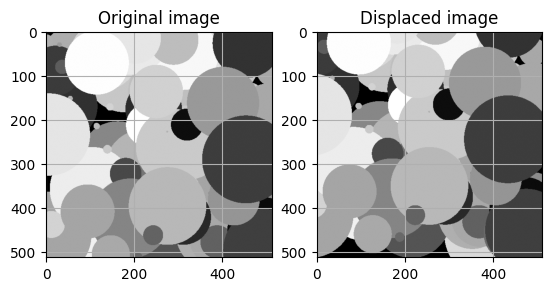

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.cbook as cbook
from numpy.random import RandomState

######## PARAMETERS #########
displacement_x = -20.5
displacement_y = -45.5
plot = True
#############################

def img_gen(dx=0, dy=0):
  x, y = 512, 512
  img = np.zeros((x, y), dtype=float)
  prng = RandomState(1234)
  circ = prng.rand(100, 4)
  Y, X = np.meshgrid(range(x), range(y))
  for i in range(circ.shape[0]):
    mask = (X-dx-circ[i,0]*x)**2 + (Y-dy-circ[i,1]*y)**2 < (circ[i,2]*100)**2
    img[mask.transpose()] = circ[i,3]
  return img

f = img_gen()
g = img_gen(displacement_x, displacement_y)

if plot is True:
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(np.log(f+1), cmap='gray')
  title = plt.title('Original image')
  plt.grid()
  plt.subplot(1,2,2)
  plt.imshow(np.log(g+1), cmap='gray')
  title = plt.title('Displaced image')
  plt.grid()

É calculada a matriz de cross-correção $\mathbf{Q}$ (cross power spectrum).  Note que a IFFT de $\mathbf{Q}$ é $\mathbf{q}$, o que fornece uma estimativa aproxida da disparidade com deslocamentos inteiros em pixels.

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3327140894.py:13: SyntaxWarning: invalid escape sequence '\m'
  title = plt.title('$\mathbf{q}$')
/tmp/ipython-input-3327140894.py:16: SyntaxWarning: invalid escape sequence '\O'
  plt.xlabel('$\Omega_y$ [rad/sample]'), plt.ylabel('$\Omega_x$ [rad/sample]')
/tmp/ipython-input-3327140894.py:16: SyntaxWarning: invalid escape sequence '\O'
  plt.xlabel('$\Omega_y$ [rad/sample]'), plt.ylabel('$\Omega_x$ [rad/sample]')
/tmp/ipython-input-3327140894.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\\angle(\mathbf{Q})$')


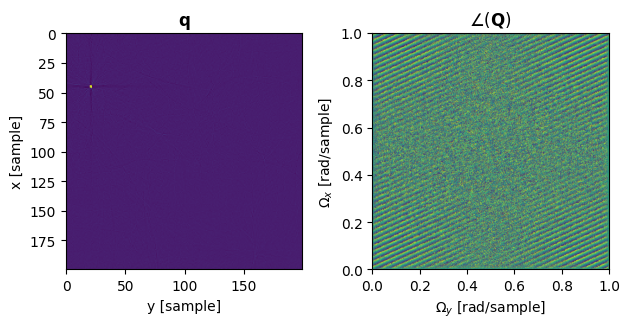

In [ ]:
from scipy.fft import fft2, ifft2, fftfreq, fftshift

F = fft2(f,s=(2048, 2048))
G = fft2(g,s=(2048, 2048))
Q = F * G.conjugate() / (np.abs(F)*(np.abs(G)))
q = np.real(ifft2(Q))

if plot is True:
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(q[:200, :200])
  plt.xlabel('y [sample]'), plt.ylabel('x [sample]')
  title = plt.title('$\mathbf{q}$')
  plt.subplot(1, 2, 2)
  plt.imshow(np.angle(Q), extent=[0, 1, 0, 1])
  plt.xlabel('$\Omega_y$ [rad/sample]'), plt.ylabel('$\Omega_x$ [rad/sample]')
  plt.title('$\\angle(\mathbf{Q})$')
  plt.tight_layout()

É necessário separar as duas correlações de fase 1-D utilizando uma fatorização de rank-1 da matrix de correlação (com decomposição SVD).

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-1962442887.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathbf{u}$')
/tmp/ipython-input-1962442887.py:22: SyntaxWarning: invalid escape sequence '\O'
  plt.xlabel('$\Omega_x$ [rad/sample]')
/tmp/ipython-input-1962442887.py:26: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathbf{v}$')
/tmp/ipython-input-1962442887.py:29: SyntaxWarning: invalid escape sequence '\O'
  plt.xlabel('$\Omega_y$ [rad/sample]')


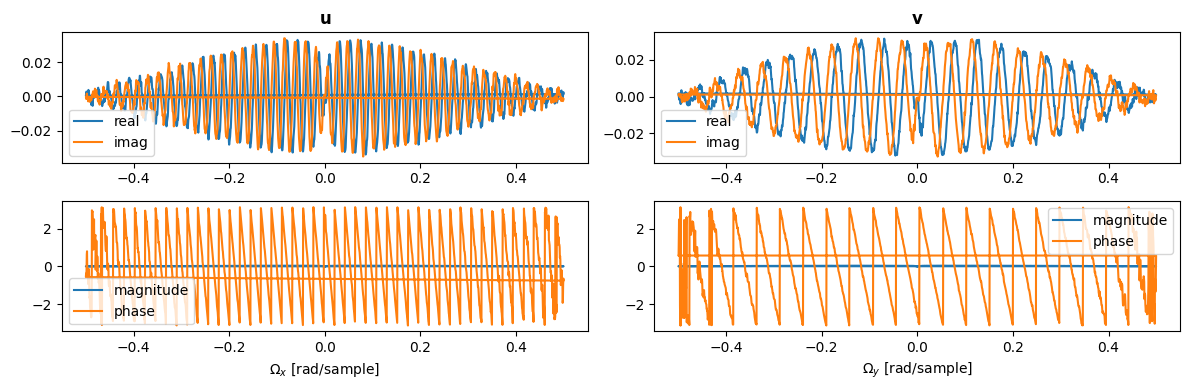

In [ ]:
from scipy.sparse.linalg import svds

u, s, v = svds(Q, 1)
u, v = u[:, 0], v[0, :]
u_angle, v_angle = np.angle(u), np.angle(v)
omega_u = fftfreq(len(u))
omega_v = fftfreq(len(v))

shift = False
if shift is True:
  u, v = fftshift(u), fftshift(v)
  omega_u, omega_v = fftshift(omega_u), fftshift(omega_v)

if plot is True:
  plt.figure(figsize=(12, 4))
  plt.subplot(2,2,1), plt.plot(omega_u, np.real(u)), plt.plot(omega_u, np.imag(u))
  #plt.subplot(2,2,1), plt.plot(np.real(u)), plt.plot(np.imag(u))
  plt.legend(['real', 'imag'])
  plt.title('$\mathbf{u}$')
  plt.subplot(2,2,3), plt.plot(omega_u, np.abs(u)), plt.plot(omega_u, u_angle)
  plt.legend(['magnitude', 'phase'])
  plt.xlabel('$\Omega_x$ [rad/sample]')

  plt.subplot(2,2,2), plt.plot(omega_v, np.real(v)), plt.plot(omega_v, np.imag(v))
  plt.legend(['real', 'imag'])
  plt.title('$\mathbf{v}$')
  plt.subplot(2,2,4), plt.plot(omega_v, np.abs(v)), plt.plot(omega_v, v_angle)
  plt.legend(['magnitude', 'phase'])
  plt.xlabel('$\Omega_y$ [rad/sample]')

  plt.tight_layout()

Nessa etapa é relizado o desempacotamento de fase (phase unwrapping) utilizando PLIM. O método proposto deriva o sinal embrulhado através do método das diferenças finitas de primeira ordem e identifica os picos no sinal derivado.

É necessário realiazar o pré-processamento do sinal utilizado para efetuar a detecção de picos. Para tanto, é calculada a diferença finita de primeira ordem do sinal original e são removidas outra descontinuidades além da descontinuidade de fase.

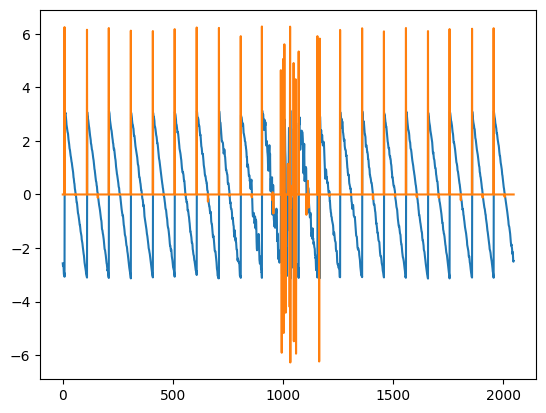

In [ ]:
v_angle_mod =v_angle*np.sign(v_angle)
df = np.roll(v_angle,-1)-v_angle
dfm = np.roll(v_angle_mod,-1)-v_angle_mod
dfp = df - dfm*np.sign(v_angle)
plt.figure()
plt.plot(v_angle)
plt.plot(dfp)

Na sequência são detectados os picos do sinal com a biblioteca scipy. A função é find_peaks aplicada no sentido positivos e negativo, considerando que o sentido com o maior número de picos é o correto. Dessa forma, essa metodologia de destecção de picos se restringe a sinais puramente crescentes ou decrescente no trecho analizado.

In [ ]:
from scipy.signal import find_peaks
peaks0, idx = find_peaks(dfp)
peaks1, idx = find_peaks(dfp*-1)
if(np.mean(peaks0)>np.mean(peaks1)):
  peaks = peaks0
  inc = 1
else:
  peaks = peaks1
  inc = -1

Em seguinda, considera-se que a quantidade de amostras entre picos válidos que efetivamente indicam descontinuidade de fase coerentes é semelhante. Dessa forma, é calculado o limiar que define o intervado mínimo em número de amostras para que uma descontinuidade seja considerada válida. Para tanto, é utilizado o método de otsu. O histograma das quantidades de amostras entre possíveis descontinuidades ilustra esse princípio.

limiar: 48


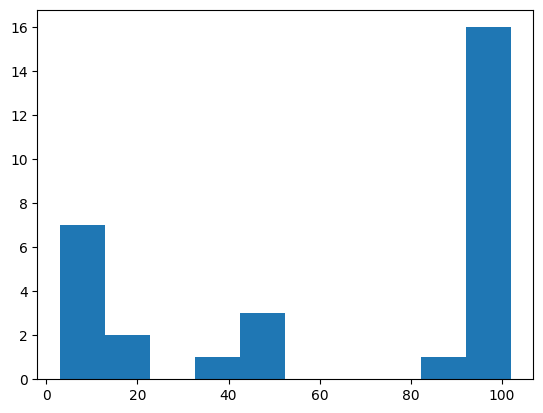

In [ ]:
from skimage.filters import threshold_otsu

plt.figure()
plt.hist(np.diff(peaks))
th_otsu = threshold_otsu(np.diff(peaks))

df_peaks = np.diff(peaks)
df_peaks_norm = (df_peaks-df_peaks.min())/(df_peaks.max()-df_peaks.min())
print("limiar:",th_otsu)


Após a determinação do limiar, é utilizada a detecção de picos novamente coniderando um intravalo mínimo entre descontinidade de fase. O gráfico abaixo mostra os picos identificados.

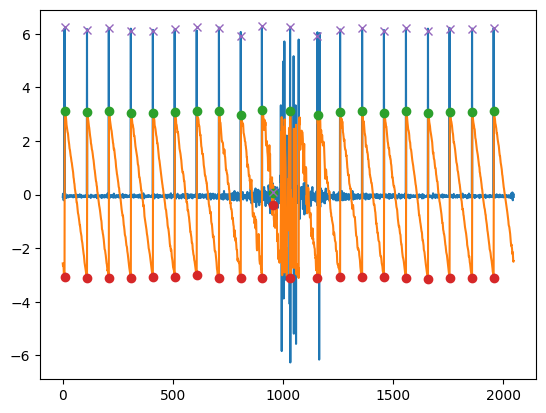

In [ ]:
peaks, idx = find_peaks(dfp, distance=th_otsu)

plt.figure()

plt.plot(df)
plt.plot(v_angle)
plt.plot(peaks+1,v_angle[peaks+1],"o")
plt.plot(peaks,v_angle[peaks],"o")
plt.plot(peaks,dfp[peaks],"x")

Após a detecção de picos, são calculados os valores para correção de descontinuidade de fase utilizando programação linear.

Para tanto, é necessário primeiramente instalar a biblioteca pulp que trabalha com programação linear no python.

In [ ]:
pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 40.5 MB/s eta 0:00:00


Após a instalção da bilioteca, repartimos após as amostras próximas dos picos detectados. Assim, utilizado programação linear para definir múltiplos inteiros de 2pi que minimizam a diferença entre as amostras mais pŕoximas a descontinuidade de fase detectada. A figura gerada demonstra as contantes identificadas.

<StemContainer object of 3 artists>

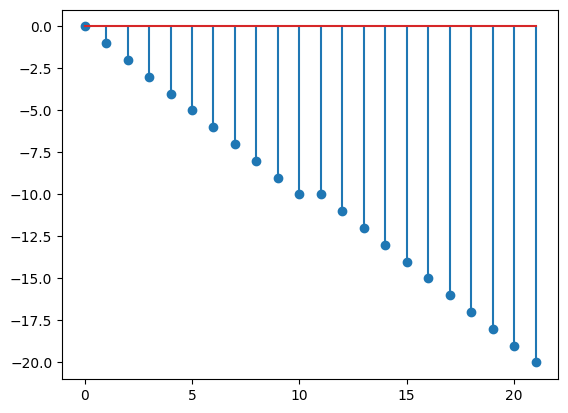

In [ ]:
import pulp

sig0 = v_angle[peaks]
sig1 = v_angle[peaks+1]

df_win = 1

n_viz = 1

N = len(sig0)

# Problema MILP
prob = pulp.LpProblem("PhaseUnwrap1D_k", pulp.LpMinimize)

# Variáveis
k = pulp.LpVariable.dicts("k", range(N+1), lowBound=None, upBound=None, cat="Integer")
u = pulp.LpVariable.dicts("u", range(N), lowBound=0, cat="Continuous")

# Função objetivo: minimizar a soma das diferenças absolutas das amostras próximas as descontinidades detectadas
prob += pulp.lpSum([u[n] for n in range(N)])

# Restrições
for n in range(N):
    diff = (sig1[n] + 2*np.pi * (k[n+1])) - (sig0[n] + 2*np.pi* (k[n]))# - dpsi[n]
    prob += u[n] >= diff
    prob += u[n] >= -diff

# Fixar a referência: k[0] = 0 para evitar ambiguidade
prob += k[0] == 0

# Resolver
prob.solve(pulp.PULP_CBC_CMD(msg=0))

# Extrair solução
k_sol = np.array([pulp.value(k[n]) for n in range(N+1)])

plt.figure()
plt.stem(k_sol)

Assim utilizamos os múltiplos inteiros de 2 pi determidados pelo algorítmo de programação linear para recontruir o sinal original, removendo descontinidades.

2048 21


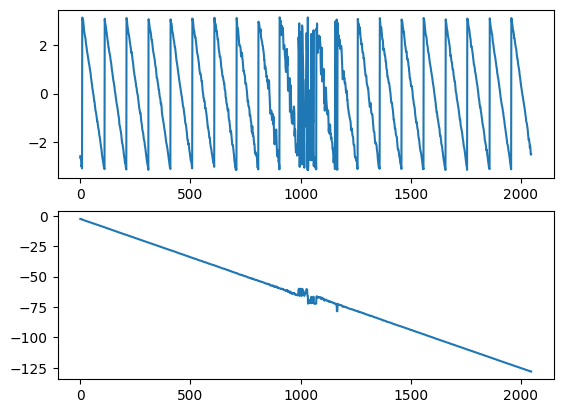

In [ ]:
print(len(v_angle),len(peaks))
res = np.zeros_like(v_angle)
t = np.zeros_like(v_angle)
last = 0
for i in range(len(peaks)):
  res[last:peaks[i]+1] = v_angle[last:peaks[i]+1]+2*np.pi*k_sol[i]
  t[last:peaks[i]+1] = k_sol[i]
  last = peaks[i]+1
res[last:] = v_angle[last:]+2*np.pi*k_sol[-1]
t[last:] = k_sol[-1]
plt.figure()
plt.subplot(2,1,1)
plt.plot(v_angle)
plt.subplot(2,1,2)
plt.plot(res)

Com base no sinal reconstuído, podemos estimar a disparidade entre imgaens em um dos eixos. Assim, fica evidente o funcionamento de algorítimo de programação linear desenvolvido.

In [ ]:
from numpy.linalg import lstsq
v_unwrap = res
v_restored = np.cumsum(v_unwrap)
#v_restored = v_restored - np.mean(v_restored)
v_restored = res
b = lstsq(np.array([omega_v[1:200], np.ones_like(omega_v[1:200])]).transpose(),
          v_restored[1:200], rcond=None)[0]
print('x: ' + str(b[0]/(2*np.pi)) + ' pixels')


x: -20.512828799074313 pixels
